In [35]:
## MACHINE LEARNING PROJECT
## CO₂ Emission Forecasting for Countries and Sectors

In [36]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [37]:
# Load Dataset
df = pd.read_csv("carbonmonitor-global_datas_2025-11-14.csv")

In [38]:
df.head()

,country,date,sector,value,Unnamed: 4
0,Brazil,01/01/2019,Industry,0.337191,NaN
1,Brazil,01/01/2019,Ground Transport,0.215540,NaN
2,Brazil,01/01/2019,International Aviation,0.020050,NaN
3,Brazil,01/01/2019,Domestic Aviation,0.019680,NaN
4,Brazil,01/01/2019,Residential,0.107550,NaN


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207060 entries, 0 to 207059
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   country     207060 non-null  object 
 1   date        207060 non-null  object 
 2   sector      207060 non-null  object 
 3   value       207060 non-null  float64
 4   Unnamed: 4  0 non-null       float64
dtypes: float64(2), object(3)
memory usage: 7.9+ MB


In [40]:
df.describe()

,value,Unnamed: 4
count,207060.000000,0.0
mean,2.508610,NaN
std,6.341806,NaN
min,0.000150,NaN
25%,0.072872,NaN
50%,0.330291,NaN
75%,1.594165,NaN
max,43.882400,NaN


In [4]:
# Drop the 5th column
df = df.drop(df.columns[4], axis=1)
print(df.columns)

Index(['country', 'date', 'sector', 'value'], dtype='object')


In [5]:
# Convert 'date' to datetime and extract year/month
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [6]:
df

,country,date,sector,value,year,month
0,Brazil,2019-01-01,Industry,0.337191,2019,1
1,Brazil,2019-01-01,Ground Transport,0.215540,2019,1
2,Brazil,2019-01-01,International Aviation,0.020050,2019,1
3,Brazil,2019-01-01,Domestic Aviation,0.019680,2019,1
4,Brazil,2019-01-01,Residential,0.107550,2019,1
...,...,...,...,...,...,...
207055,WORLD,2025-09-30,Ground Transport,20.111400,2025,9
207056,WORLD,2025-09-30,Industry,38.007900,2025,9
207057,WORLD,2025-09-30,International Aviation,1.883720,2025,9
207058,WORLD,2025-09-30,Power,36.734400,2025,9


In [7]:
# BASIC DATA EXPLORATION
# How many unique countries and sectors
num_countries = df['country'].nunique()
num_sectors = df['sector'].nunique()
print(f"Number of countries: {num_countries}")
print(df['country'].unique())
print(f"Number of sectors: {num_sectors}")
print(df['sector'].unique())

Number of countries: 14
['Brazil' 'China' 'EU27 & UK' 'France' 'Germany' 'India' 'Italy' 'Japan'
 'ROW' 'Russia' 'Spain' 'United Kingdom' 'United States' 'WORLD']
Number of sectors: 6
['Industry' 'Ground Transport' 'International Aviation'
 'Domestic Aviation' 'Residential' 'Power']


In [8]:
# One-Hot Encoding for 'country' and 'sector'
cat_cols = ['country','sector']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoder.fit(df[cat_cols])

# Create encoded feature dataframe
encoded_df = pd.DataFrame(encoder.transform(df[cat_cols]), columns=encoder.get_feature_names_out(cat_cols))
df_encoded = pd.concat([df.reset_index(drop=True), encoded_df], axis=1)
df_encoded = df_encoded.drop(cat_cols, axis=1)

In [9]:
df_encoded

,date,value,year,month,country_China,country_EU27 & UK,country_France,country_Germany,country_India,country_Italy,...,country_Russia,country_Spain,country_United Kingdom,country_United States,country_WORLD,sector_Ground Transport,sector_Industry,sector_International Aviation,sector_Power,sector_Residential
0,2019-01-01,0.337191,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2019-01-01,0.215540,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2019-01-01,0.020050,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2019-01-01,0.019680,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-01-01,0.107550,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207055,2025-09-30,20.111400,2025,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
207056,2025-09-30,38.007900,2025,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
207057,2025-09-30,1.883720,2025,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
207058,2025-09-30,36.734400,2025,9,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [10]:
# Ensure df_encoded is sorted by date
df_encoded = df_encoded.sort_values('date')

# Train/Test Split: first 80% for training, last 20% for test
split_idx = int(len(df_encoded) * 0.8)
train_df = df_encoded.iloc[:split_idx]  # first 80%
test_df  = df_encoded.iloc[split_idx:]  # last 20%

# Features and target
X_train = train_df.drop(['value','date'], axis=1)
y_train = train_df['value']
X_test  = test_df.drop(['value','date'], axis=1)
y_test  = test_df['value']

In [11]:
X_train

,year,month,country_China,country_EU27 & UK,country_France,country_Germany,country_India,country_Italy,country_Japan,country_ROW,country_Russia,country_Spain,country_United Kingdom,country_United States,country_WORLD,sector_Ground Transport,sector_Industry,sector_International Aviation,sector_Power,sector_Residential
0,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
60,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
59,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
58,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
57,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165588,2024,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
165587,2024,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
165586,2024,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
165585,2024,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
y_train

0         0.337191
60        0.183461
59        2.296630
58        1.211950
57        0.018057
            ...   
165588    0.442254
165587    0.011438
165586    0.068071
165585    0.010284
165593    0.306184
Name: value, Length: 165648, dtype: float64

In [13]:
# Train Random Forest 
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [14]:
rf_preds = rf_model.predict(X_test)

In [15]:
# XGBoost Models
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [16]:
xgb_preds = xgb_model.predict(X_test)

In [17]:
# Regression Metrics
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, mape, r2

In [18]:
# PERFORMANCE SUMMARY
metrics_df = pd.DataFrame({
'Model': ['Random Forest','XGBoost'],
'MAE': [*regression_metrics(y_test, rf_preds)[:1], *regression_metrics(y_test, xgb_preds)[:1]],
'RMSE': [*regression_metrics(y_test, rf_preds)[1:2], *regression_metrics(y_test, xgb_preds)[1:2]],
'MAPE (%)': [*regression_metrics(y_test, rf_preds)[2:3], *regression_metrics(y_test, xgb_preds)[2:3]],
'R² Score': [*regression_metrics(y_test, rf_preds)[3:], *regression_metrics(y_test, xgb_preds)[3:]]
})

print(metrics_df)

           Model       MAE      RMSE   MAPE (%)  R² Score
0  Random Forest  0.151047  0.386627  12.138922  0.996460
1        XGBoost  0.175220  0.384196  89.382042  0.996505


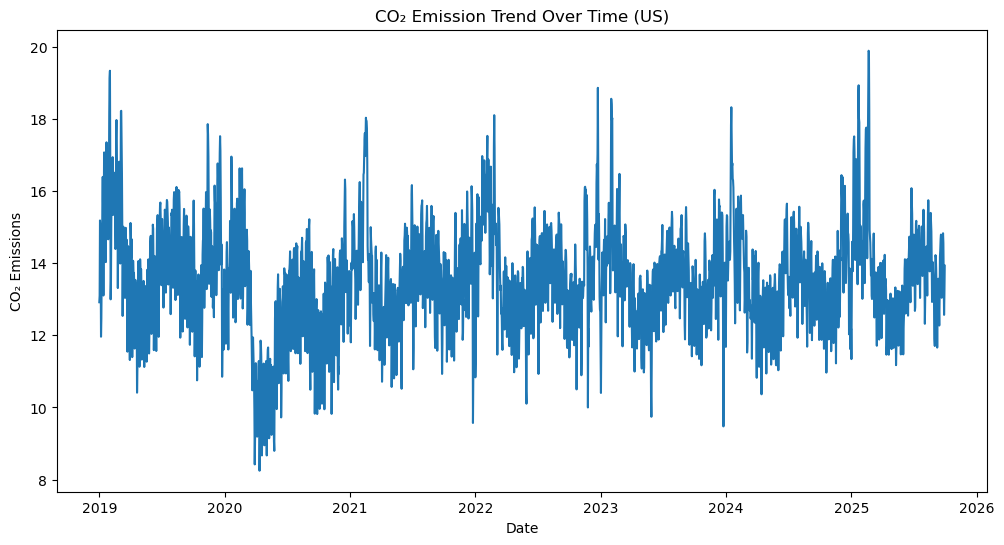

In [19]:
# Visualizations
# Plot 1: CO₂ Emission Trend Over Time
us_df = df[df['country']=='United States'].groupby('date')['value'].sum().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=us_df, x='date', y='value')
plt.title("CO₂ Emission Trend Over Time (US)")
plt.xlabel("Date")
plt.ylabel("CO₂ Emissions")
plt.show()

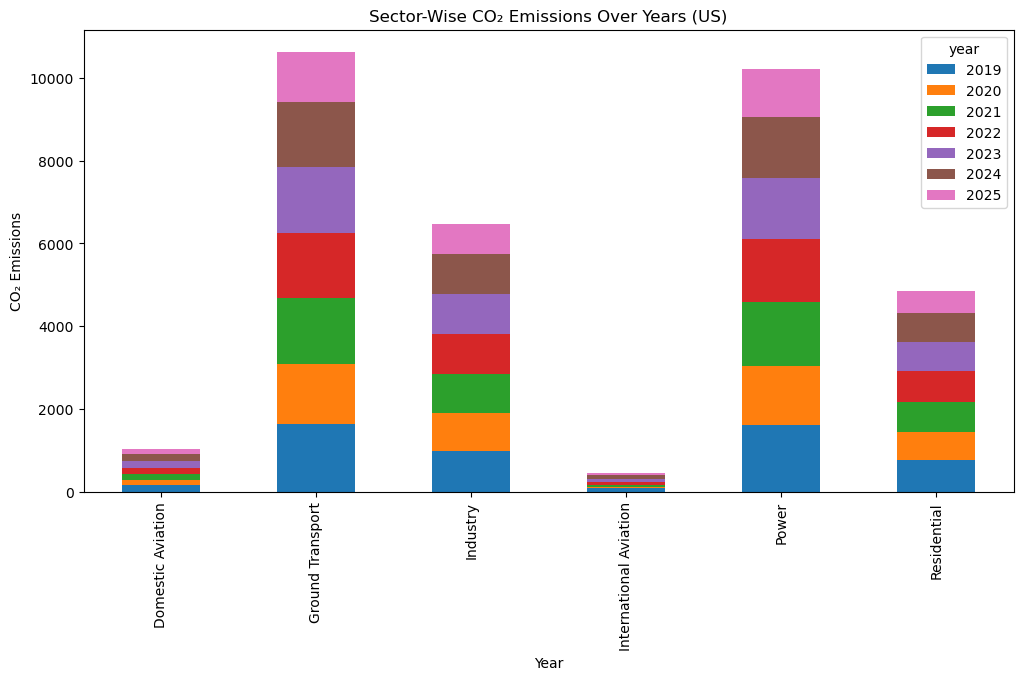

In [20]:
# Plot 2: Sector-Wise Emission Variation
us_sector_df = df[df['country']=='United States'].groupby(['sector','year'])['value'].sum().unstack()
us_sector_df.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title("Sector-Wise CO₂ Emissions Over Years (US)")
plt.xlabel("Year")
plt.ylabel("CO₂ Emissions")
plt.show()

/var/folders/dj/pl76klcn6p5952pbjb7_xdxm0000gn/T/ipykernel_59651/3976535986.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, ax=axes[i], palette="Set2")
/var/folders/dj/pl76klcn6p5952pbjb7_xdxm0000gn/T/ipykernel_59651/3976535986.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metrics_df, ax=axes[i], palette="Set2")
/var/folders/dj/pl76klcn6p5952pbjb7_xdxm0000gn/T/ipykernel_59651/3976535986.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=metri

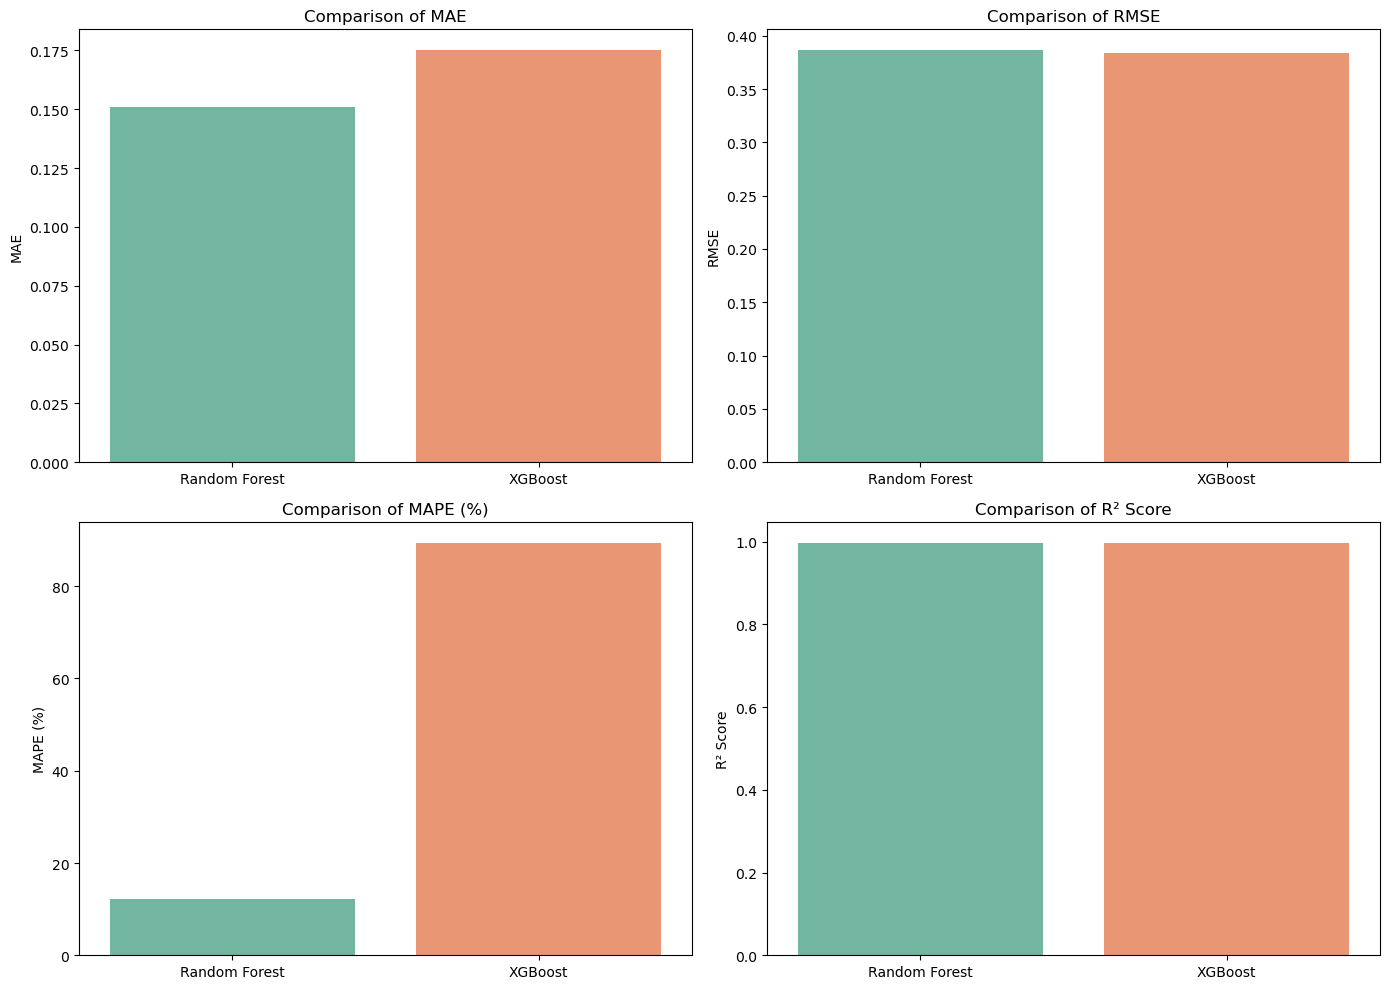

In [21]:
# Model Comparison Bar Chart

metrics_to_plot = ['MAE', 'RMSE', 'MAPE (%)', 'R² Score']

fig, axes = plt.subplots(2, 2, figsize=(14,10))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(x='Model', y=metric, data=metrics_df, ax=axes[i], palette="Set2")
    axes[i].set_title(f"Comparison of {metric}")
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("")

plt.tight_layout()
plt.show()

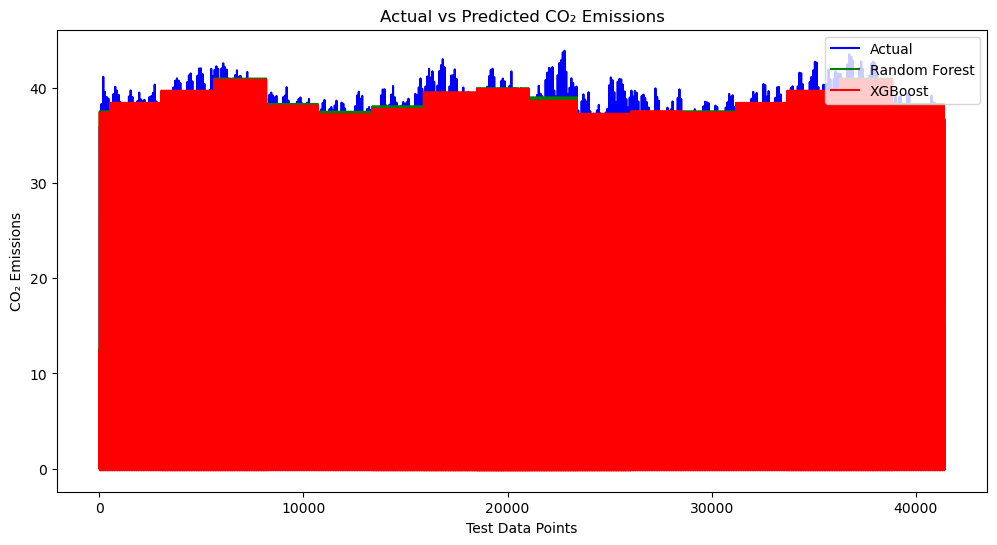

In [22]:
# Plot 4: Actual vs Predicted Plot
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual', color='blue')
plt.plot(rf_preds, label='Random Forest', color='green')
plt.plot(xgb_preds, label='XGBoost', color='red')
plt.title("Actual vs Predicted CO₂ Emissions")
plt.xlabel("Test Data Points")
plt.ylabel("CO₂ Emissions")
plt.legend()
plt.show()

In [23]:
# High emission sectors
sector_sum = df.groupby('sector')['value'].sum().sort_values(ascending=False)
print(sector_sum)

# High emission countries
country_sum = df.groupby('country')['value'].sum().sort_values(ascending=False)
print(country_sum)

sector
Industry                  185068.120911
Power                     179459.345433
Ground Transport           93095.463677
Residential                49384.575620
International Aviation      7653.132653
Domestic Aviation           4772.159770
Name: value, dtype: float64
country
WORLD             253356.485168
ROW                79941.108038
China              78760.619507
United States      33649.940801
EU27 & UK          20518.035665
India              19251.602111
Russia             11104.576666
Japan               6957.196299
Germany             4468.779432
Brazil              3173.407084
United Kingdom      2402.516890
Italy               2213.855881
France              2042.086414
Spain               1592.588109
Name: value, dtype: float64


/var/folders/dj/pl76klcn6p5952pbjb7_xdxm0000gn/T/ipykernel_59651/2318738740.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sector_sum.index, y=sector_sum.values, palette="Reds_r")


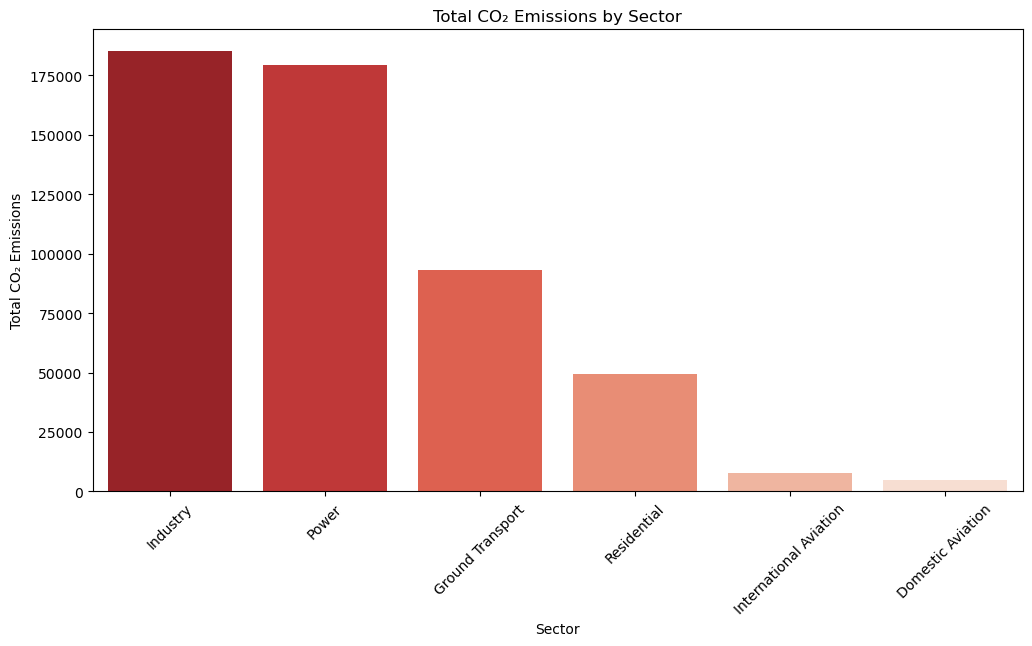

In [25]:
# High Emission Sectors Plot

plt.figure(figsize=(12,6))
sns.barplot(x=sector_sum.index, y=sector_sum.values, palette="Reds_r")
plt.xticks(rotation=45)
plt.title("Total CO₂ Emissions by Sector")
plt.xlabel("Sector")
plt.ylabel("Total CO₂ Emissions")
plt.show()

/var/folders/dj/pl76klcn6p5952pbjb7_xdxm0000gn/T/ipykernel_59651/1562900964.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_sum.index, y=country_sum.values, palette="viridis")


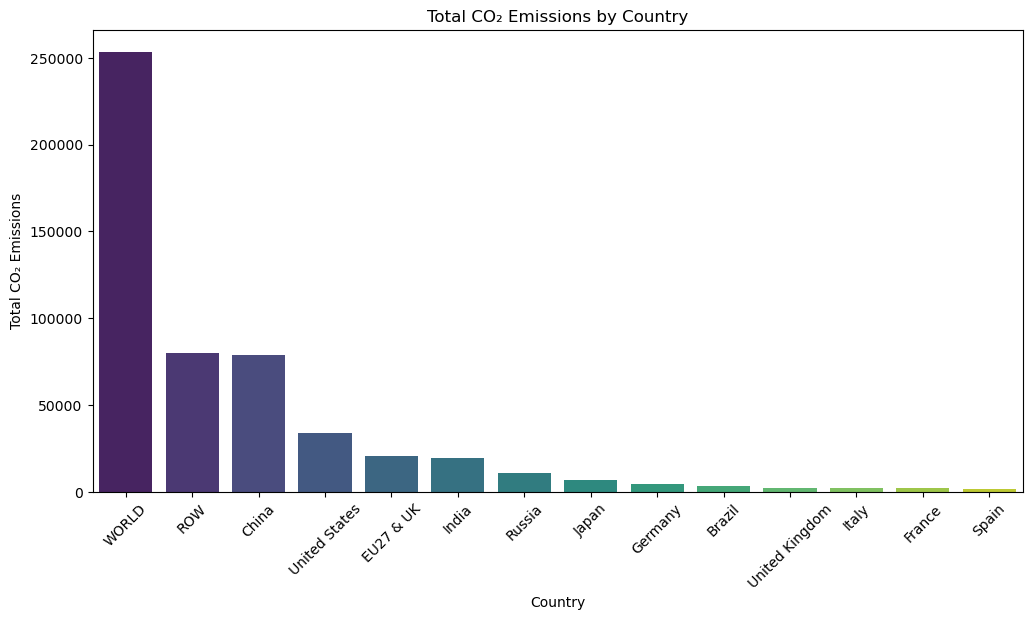

In [26]:
# High Emission Countries Plot

plt.figure(figsize=(12,6))
sns.barplot(x=country_sum.index, y=country_sum.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Total CO₂ Emissions by Country")
plt.xlabel("Country")
plt.ylabel("Total CO₂ Emissions")
plt.show()

Available countries: ['Brazil' 'China' 'EU27 & UK' 'France' 'Germany' 'India' 'Italy' 'Japan'
 'ROW' 'Russia' 'Spain' 'United Kingdom' 'United States' 'WORLD']


Enter a country name from the above list:  China


         date    sector  predicted_CO2_RF  predicted_CO2_XGB
0  2025-10-31  Industry         14.989561          14.664032
1  2025-11-30  Industry         14.940657          14.707436
2  2025-12-31  Industry         13.250692          13.712403
3  2026-01-31  Industry         14.155949          13.566779
4  2026-02-28  Industry         11.517119          12.450398
..        ...       ...               ...                ...
7  2026-05-31     Power         11.250589          11.912634
8  2026-06-30     Power         13.744644          13.089294
9  2026-07-31     Power         14.697301          14.495956
10 2026-08-31     Power         15.806765          15.103971
11 2026-09-30     Power         12.628293          12.777736

[72 rows x 4 columns]


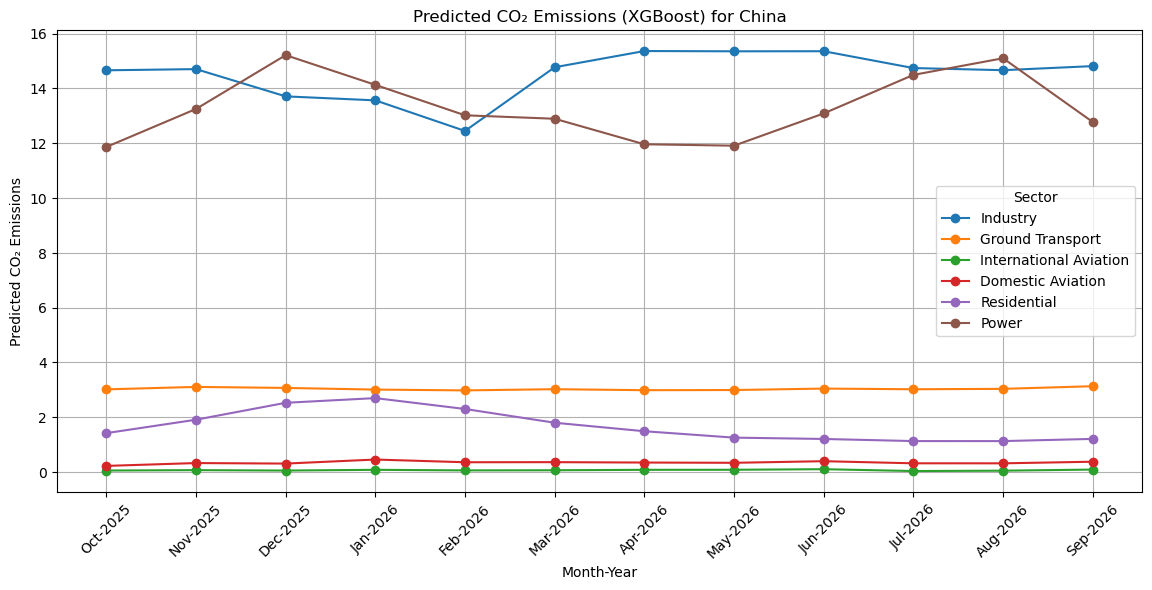

In [24]:
# Interactive Prediction - Fixed Column Alignment

available_countries = df['country'].unique()
print("Available countries:", available_countries)
country_input = input("Enter a country name from the above list: ")

if country_input not in available_countries:
    print("Country not found. Please enter a valid country name.")
else:country_sectors = df[df['country']==country_input]['sector'].unique()
last_date = df['date'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=12, freq='ME')
future_df = pd.DataFrame()

for sector in country_sectors:
    temp_df = pd.DataFrame({
        'country': country_input,
        'sector': sector,
        'year': future_dates.year,
        'month': future_dates.month,
        'date': future_dates
    })
    future_df = pd.concat([future_df, temp_df], axis=0)

# Encode
future_encoded = encoder.transform(future_df[['country','sector']])
future_encoded_df = pd.DataFrame(future_encoded, columns=encoder.get_feature_names_out(['country','sector']))

# Add year and month
X_future = pd.concat([future_encoded_df.reset_index(drop=True), future_df[['year','month']].reset_index(drop=True)], axis=1)

# Ensure same column order as training
X_future = X_future[X_train.columns]

# Predict
future_df['predicted_CO2_RF'] = rf_model.predict(X_future)
future_df['predicted_CO2_XGB'] = xgb_model.predict(X_future)
future_df['month_year'] = future_df['date'].dt.strftime('%b-%Y')
print(future_df[['date','sector','predicted_CO2_RF','predicted_CO2_XGB']])

# Plot
# Plot future predictions as line plot for XGBoost

plt.figure(figsize=(14,6))
for sector in country_sectors:
    sector_data = future_df[future_df['sector']==sector]
    plt.plot(sector_data['month_year'], sector_data['predicted_CO2_XGB'], marker='o', label=sector)

plt.xticks(rotation=45)
plt.title(f"Predicted CO₂ Emissions (XGBoost) for {country_input}")
plt.xlabel("Month-Year")
plt.ylabel("Predicted CO₂ Emissions")
plt.legend(title='Sector')
plt.grid(True)
plt.show()